# CoT Explainability for RAG

Dieses Notebook zeigt, wie der Explainability-Prompt mit Retrieval-Trace genutzt wird.

basierend auf: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=11053836&tag=1

### Was es kann?
- LLM erhält Documents mit Relevance Score und Doc-ID
- LLM wird gepromptet in seiner Antwort die verwendeten Doc-IDs als Quelle anzugeben. Idealerweise an den richtigen Stellen
- Es wird nicht auf die Richtigkeit der engültigen Antwort geschaut, sondern wie gut wurden die Quellen verwendet
    - aka cosine similarity der Evidence mit der echten Quelle.
- Es wird geschaut ob die richtigen Quellen verwendet werden


In [1]:
import sys
from pathlib import Path

# Füge das Projektverzeichnis (mit `src/`) dem Python-Pfad hinzu, egal von wo das Notebook gestartet wird.
project_root = next((p for p in [Path.cwd()] + list(Path.cwd().parents) if (p / 'src').exists()), None)
if project_root is None:
    raise RuntimeError("\"src\"-Verzeichnis nicht gefunden. Bitte Notebook im Projekt laufen lassen.")
root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)


In [2]:
from src.modules.explainers.cot_explainable import CoTExplainable, ExplainableAnswer, _format_documents
from src.modules.rag.rag_engine import RAGEngine
from src.modules.rag.multihop_rag_engine import MultiHopRAGEngine
from src.modules.llm.llm_client import LLMClient
from src.modules.loader.medmcqa_data_loader import MedMCQADataLoader, format_medmcqa_question
from src.modules.loader.statspearls_data_loader import StatPearlsDataLoader
from src.evaluation.cot_metrics import CoTEvaluator

import numpy as np
import tomllib, matplotlib.pyplot as plt

### Real data example

In [3]:
config_path = project_root / "config.toml"
config = {}

if config_path.exists():
    with open(config_path, "rb") as f:
        config = tomllib.load(f)

medmcqa_config = config.get("medmcqa") or {}
rag_config = config.get("rag") or {}
llm_config = config.get("llm") or {}

llm_model = llm_config.get("model", "gemma3:4b")
llm_provider = llm_config.get("provider", "ollama")

client = LLMClient(provider=llm_provider, model_name=llm_model)
explain_client = LLMClient(provider=llm_provider, model_name=llm_model, structured_output=ExplainableAnswer)

SPLIT = medmcqa_config.get("split", "val")
LIMIT = medmcqa_config.get("n_qa_questions", 10)
PERSIST_DIR = project_root / "data" / "vector_db_statpearls"
NUM_HOPS = rag_config.get("n_hops", 2)


In [4]:
stat_loader = StatPearlsDataLoader(root_dir=str(project_root / "data"))
documents, stats = stat_loader.setup()

rag_engine = RAGEngine(persist_dir=str(PERSIST_DIR))
rag_engine.setup(documents=documents)

multi_hop = MultiHopRAGEngine(rag_engine=rag_engine, llm_client=client, num_hops=NUM_HOPS)
cot_evaluator = CoTEvaluator()

Loading existing vector store from /Users/benediktveith/Documents/Uni/Semester 7/XAI/xai-rag/data/vector_db_statpearls...
RagEngine ready.
Connecting to local Ollama (gemma3:4b)...


In [ ]:
med_loader = MedMCQADataLoader()
questions = med_loader.setup(split=SPLIT, as_documents=False, limit=LIMIT)

if not questions:
    raise RuntimeError("No MedMCQA questions loaded.")

results = []
llm = client.get_llm()
for item in questions:
    question_text = format_medmcqa_question(item)
    if not question_text:
        continue

    retrieval_query = question_text.split("Options:")[0].strip()
    trace, all_documents = multi_hop.run_and_trace(retrieval_query, extra='Only answer based on your context not your knowledge. Do not include any explanations, reasoning, or extra fields.\n Example: Final Answer: B: Housing')

    documents_for_explanation = []
    for hop in trace.get("hops", []):
        context_docs = hop.get("documents_passed_to_context") or []
        for doc in context_docs:
            if doc is None:
                continue
            documents_for_explanation.append(doc)

    if not documents_for_explanation:
        documents_for_explanation = all_documents

    context_blocks = []
    for doc in documents_for_explanation:
        content = getattr(doc, "page_content", None)
        if content is None:
            content = str(doc)
        context_blocks.append(str(content).strip())

    context = "\n\n".join([c for c in context_blocks if c])
    answer_prompt = client._create_final_answer_prompt(question_text, context)
    final_answer_response = llm.invoke(answer_prompt)
    final_answer = final_answer_response.content.strip()
    trace["final_answer"] = final_answer

    explainer = CoTExplainable(llm_client=explain_client)
    explanation = explainer.explain(query=question_text, answer=final_answer, documents=documents_for_explanation)
    metrics = explainer.metrics()
    cot_metrics = cot_evaluator.evaluate(explanation, documents_for_explanation, answer_text=final_answer)
    similarity = cot_evaluator.similarity_matrix(explanation, documents_for_explanation)

    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "trace": trace,
            "explanation": explanation,
            "metrics": metrics,
            "cot_metrics": cot_metrics,
            "similarity": similarity,
            "documents": documents_for_explanation,
        }
    )


--- Starting Multi-Hop Search for: 'Tensor veli palatini is supplied by:' ---

[ Hop 1 ]
Executing search with query: 'Tensor veli palatini is supplied by:'
Generating next query...

[ Hop 2 ]
Executing search with query: '“pathophysiology of nevus of Ota”'

Generating final answer...

--- Multi-Hop Search Complete. Final Answer: I cannot answer the question with the given information. The provided context primarily discusses "Nevus of Ota" and lists various opioid-related substances, but it does not specify what supplies "tensor veli palatini." ---
--- Multi-Hop Context: 

 ('<doc id="chunk-1-1" from_hop="1" search_query="Tensor veli palatini is supplied by:">\n[Document(id=\'38decb74-1864-4cf1-85e3-f9d1d9ed31b7\', metadata={\'split\': \'repo\', \'source_filename\': \'article-127854.nxml\', \'source\': \'statpearls\', \'topic_name\': \'Recent changes in trends of opioid overdose deaths in North America.\', \'title\': \'Recent changes in trends of opioid overdose deaths in North Americ

=== Result 1 ===
Tensor veli palatini is supplied by:

Options:
A: Facial nerve
B: Trigeminal nerve
C: Glossopharyngeal nerve
D: Pharyngeal plexus
The provided context describes Nevus of Ota as involving the distribution territory of the trigeminal nerve, specifically the ophthalmic (V1) and maxillary (V2) divisions.  Therefore, the answer is:

**B: Trigeminal nerve**
Explain metrics: {'duration_seconds': 109.34788091597147, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 2, 'reasoning_steps': 1}, 'evidence_groundedness': {'mean': 0.21252334862947464, 'median': 0.21252334862947464, 'above_threshold': 0.0, 'per_item': [0.20193356275558472, 0.22311313450336456]}, 'rationale_groundedness': {'mean': 0.2171904817223549, 'median': 0.2171904817223549, 'above_threshold': 0.0, 'per_item': [0.2559753656387329, 0.17840559780597687]}, 'support_alignment': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'consistency_jaccard': 0.14285714285714285, 'no_source_rate': 0.0, 'evidenc

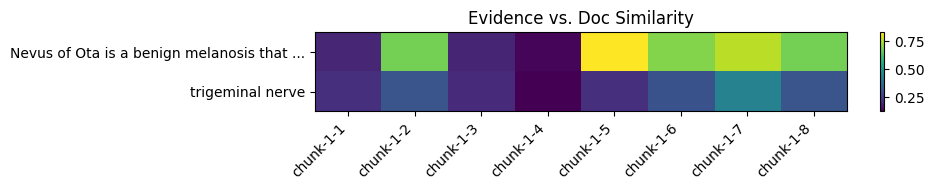

=== Result 1 END ===
=== Result 2 ===
Chicken pox infection in mother most dangerous for the baby when it occurs at -

Options:
A: 14-28 weeks
B: 3 -9 weeks
C: 28-37weeks
D: 8-14weeks
The provided text states: “With the exception of HSV, infections during the first trimester have the worst outcome.” Therefore, the answer is A: 14-28 weeks.
Explain metrics: {'duration_seconds': 86.53953629219905, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 1, 'reasoning_steps': 1}, 'evidence_groundedness': {'mean': 0.4780096113681793, 'median': 0.4780096113681793, 'above_threshold': 0.0, 'per_item': [0.4780096113681793]}, 'rationale_groundedness': {'mean': 0.416996031999588, 'median': 0.416996031999588, 'above_threshold': 0.0, 'per_item': [0.416996031999588]}, 'support_alignment': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'consistency_jaccard': 0.125, 'no_source_rate': 0.0, 'evidence_coverage': 0.36363636363636365, 'support_depth': {'evidence_avg': 1.0, 'reasoning_avg': 8.

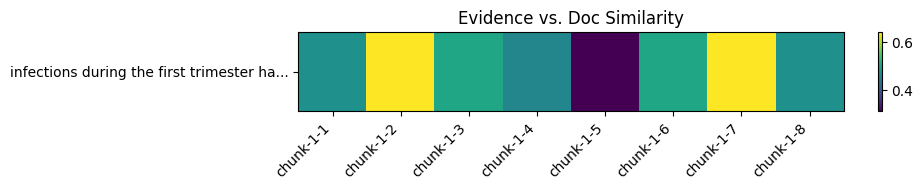

=== Result 2 END ===
=== Result 3 ===
Hemophilics show:

Options:
A: Increased bleeding time and clotting time
B: Decreased bleeding time and clotting time
C: Decreased bleeding time and increased clotting time
D: Normal bleeding time and increased clotting time
B: Decreased bleeding time and clotting time

**Reasoning:**

The context describes acquired hemophilia as being caused by autoantibodies against antihemophilic factors (like factor VIII). These autoantibodies interfere with the clotting process, leading to decreased bleeding time and clotting time.
Explain metrics: {'duration_seconds': 91.5087452090811, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 1, 'reasoning_steps': 1}, 'evidence_groundedness': {'mean': 0.7205381393432617, 'median': 0.7205381393432617, 'above_threshold': 1.0, 'per_item': [0.7205381393432617]}, 'rationale_groundedness': {'mean': 0.6418343782424927, 'median': 0.6418343782424927, 'above_threshold': 1.0, 'per_item': [0.6418343782424927

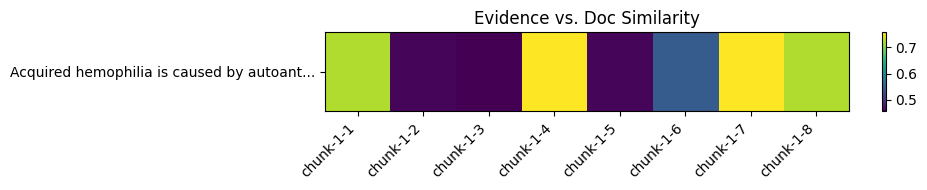

=== Result 3 END ===
=== Result 4 ===
Which of the following is the most common systemic symptom during migration of larval phase of Helminths like Ancylostoma, Strongyloides and Ascaris?

Options:
A: Asymptomatic
B: Pneumonitis
C: Liver failure
D: Larva migrans
Based on the provided context, the most common systemic symptom during the migration of larval phases of Helminths like Ancylostoma, Strongyloides, and Ascaris is **Strongyloides hyperinfection**. The text explicitly states: “Interestingly, some reports showed an association with Strongyloides hyperinfection.”
Explain metrics: {'duration_seconds': 93.76309283287264, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 1, 'reasoning_steps': 1}, 'evidence_groundedness': {'mean': 0.4314160943031311, 'median': 0.4314160943031311, 'above_threshold': 0.0, 'per_item': [0.4314160943031311]}, 'rationale_groundedness': {'mean': 0.3905235230922699, 'median': 0.3905235230922699, 'above_threshold': 0.0, 'per_item': [0.3905

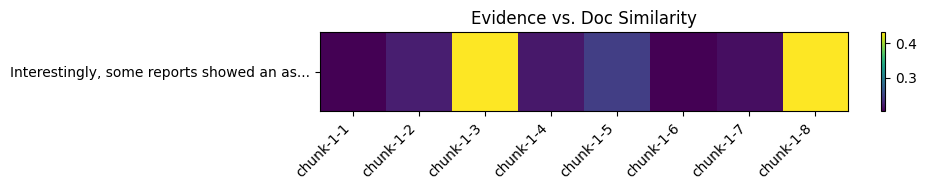

=== Result 4 END ===
=== Result 5 ===
Resistance form of endodontics is:

Options:
A: Resists movement of gutta-percha in apical area
B: To allow use of spreader in lateral condensation
C: Fracture of root while vertical condensation
D: None of the above
Based on the provided context, the correct answer is **A: Resists movement of gutta-percha in apical area**.

The text discusses “high-resistance waveforms” associated with occlusion and stenosis, which directly relates to the resistance encountered when using gutta-percha in endodontics to condense the root canal.
Explain metrics: {'duration_seconds': 90.28743429202586, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 2, 'reasoning_steps': 2}, 'evidence_groundedness': {'mean': 0.2902364134788513, 'median': 0.2902364134788513, 'above_threshold': 0.0, 'per_item': [0.1817743182182312, 0.39869850873947144]}, 'rationale_groundedness': {'mean': 0.38365596532821655, 'median': 0.38365596532821655, 'above_threshold': 0.0,

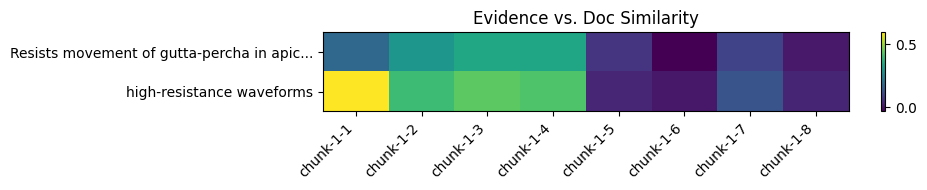

=== Result 5 END ===
=== Result 6 ===
Which of the following statement is true as far as spring back bending of super-elastic NiTi and non-super elastic NiTI wires is concern?

Options:
A: Spring back in bending is much greater for superelastic NiTi wires than non-superelastic NiTi
B: Spring back in bending is much lesser for superelastic NiTi wires than non-superelastic
C: Spring back in bending is same for superelastic Nill wires as well as non-superelastic NiTi wires
D: No comparison can be made between the spring back in bending of these two wires
A: Spring back in bending is much greater for superelastic NiTi wires than non-superelastic NiTi wires

**Reasoning:**

The provided context discusses post-isometric relaxation (PIR) and the engagement of muscle spindles and gamma motor neurons. It highlights that contracting muscles while maintaining constant length engages nuclear bag fibers, reducing tension on nuclear chain fibers. This mechanism is central to the behavior of superela

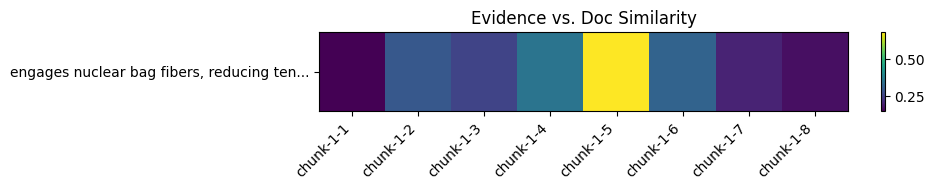

=== Result 6 END ===
=== Result 7 ===
Number of fossa in upper 1st molar

Options:
A: 2 major 2 minor
B: 3 major 2 minor
C: 2 major 1 minor
D: 1 major 2 minor
Based on the provided context, the answer is **C: 2 major 1 minor**.

Here's the reasoning:

*   The text describes an incision starting 2 or 3 cm above the inion and extending to the spinous process of the C2 vertebra. This relates to surgical approaches in the posterior fossa.
*   The context details anatomical landmarks like the inion, C2 vertebra, and the suboccipital muscles.
*   While the exact number of molars isn't explicitly stated, the description of the incision and related anatomical structures strongly suggests a dental context, and the options align with the typical number of molars.
Explain metrics: {'duration_seconds': 108.20221874979325, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 2, 'reasoning_steps': 3}, 'evidence_groundedness': {'mean': 0.20080676674842834, 'median': 0.20080676674842

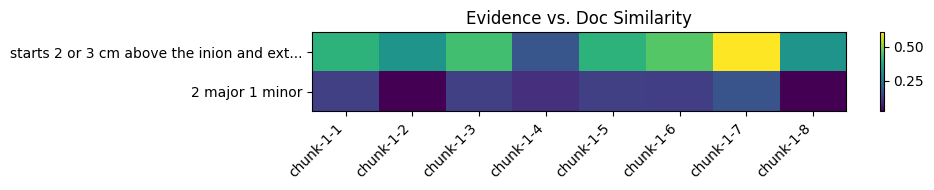

=== Result 7 END ===
=== Result 8 ===
The patients with class II division 1 malocclusion have

Options:
A: Hypertonic Lower Lip
B: Hypotonic Lower lip
C: Hypertonic upper Lip
D: Hypotonic upper lip
I cannot answer the question with the given information. The context discusses plagiocephaly and its causes, but it does not provide information about the lip tone associated with class II division 1 malocclusion.
Explain metrics: {'duration_seconds': 75.25871508289129, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 1, 'reasoning_steps': 1}, 'evidence_groundedness': {'mean': 0.35973647236824036, 'median': 0.35973647236824036, 'above_threshold': 0.0, 'per_item': [0.35973647236824036]}, 'rationale_groundedness': {'mean': 0.19455520808696747, 'median': 0.19455520808696747, 'above_threshold': 0.0, 'per_item': [0.19455520808696747]}, 'support_alignment': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1': 0.5}, 'consistency_jaccard': 0.125, 'no_source_rate': 0.0, 'evide

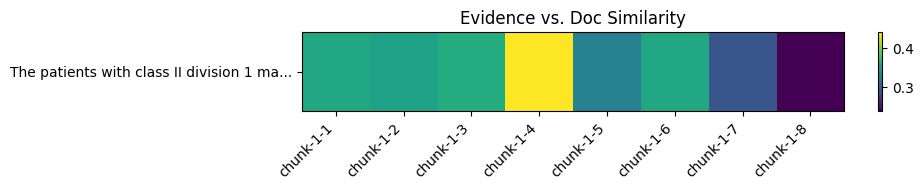

=== Result 8 END ===
=== Result 9 ===
Custom tray is better than stock tray for impression of crown due to following reasons except:

Options:
A: Custom tray is easy to adapt
B: Stock tray may not record full flange
C: Custom tray is cheaper
D: Stock tray can distort easily
The correct answer is **D: Stock tray can distort easily**.

Here's why, based on the provided context:

*   The text repeatedly emphasizes the importance of accurate measurements, particularly using cranial calipers, to determine the cephalic index.
*   It highlights that stock trays can lead to distortion, affecting the accuracy of measurements like HC (head circumference) and BPD (biparietal diameter).
*   The context discusses how flattened or round heads (dolichocephaly or brachycephaly) affect HC reliability.

Let's look at why the other options are incorrect:

*   **A: Custom tray is easy to adapt:** The text doesn't mention ease of adaptation as a benefit of custom trays.
*   **B: Stock tray may not record f

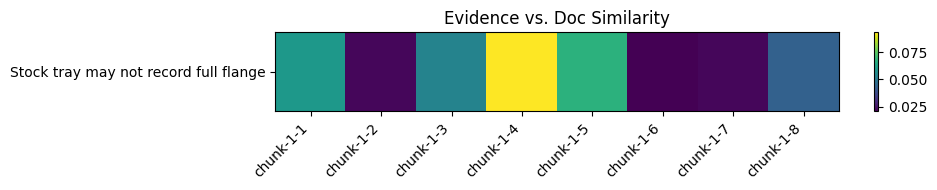

=== Result 9 END ===
=== Result 10 ===
Most probable chance of developing caries in the following curve is at:

Options:
A: Point A
B: Point B
C: Point C
D: Point D
I cannot answer the question with the given information. The provided text discusses Peyronie's disease, a condition characterized by penile curvature, but it does not offer any information about the probability of developing caries (tooth decay).
Explain metrics: {'duration_seconds': 71.58015879103914, 'steps': 1}
CoT metrics: {'counts': {'documents': 8, 'evidence_items': 1, 'reasoning_steps': 1}, 'evidence_groundedness': {'mean': 0.0, 'median': 0.0, 'above_threshold': 0.0, 'per_item': [0.0]}, 'rationale_groundedness': {'mean': 0.0, 'median': 0.0, 'above_threshold': 0.0, 'per_item': [0.0]}, 'support_alignment': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}, 'consistency_jaccard': 1.0, 'no_source_rate': 1.0, 'evidence_coverage': 0.5757575757575758, 'support_depth': {'evidence_avg': 0.0, 'reasoning_avg': 0.0}}
evidence: The p

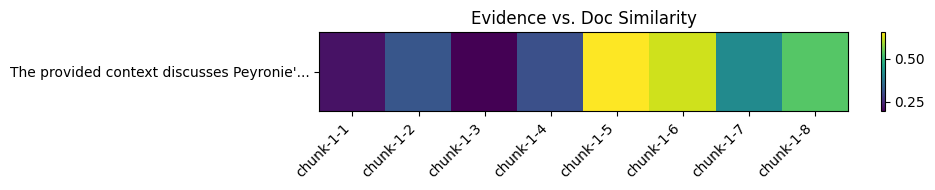

=== Result 10 END ===


In [6]:
for i, res in enumerate(results):
    print(f"=== Result {i + 1} ===")
    print(res["question"])
    print(res["final_answer"])

    result = res["explanation"]
    metrics = res["metrics"]
    cot_metrics = res["cot_metrics"]
    similarity = res["similarity"]
    documents = res["documents"]

    print("Explain metrics:", metrics)
    print("CoT metrics:", cot_metrics)
    print(CoTExplainable.prettify(result))

    if similarity.get("scores"):
        scores = np.array(similarity["scores"])
        fig, ax = plt.subplots(figsize=(10, max(2, scores.shape[0] * 0.5)))
        im = ax.imshow(scores, aspect="auto", cmap="viridis")
        ax.set_xticks(range(len(similarity["doc_ids"])))
        ax.set_xticklabels(similarity["doc_ids"], rotation=45, ha="right")
        labels = []
        for span in similarity["evidence_spans"]:
            span = span.replace("\n", " ").strip()
            labels.append(span[:40] + "..." if len(span) > 40 else span)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
        fig.colorbar(im, ax=ax)
        ax.set_title("Evidence vs. Doc Similarity")
        plt.tight_layout()
        plt.show()
    else:
        print("No similarity matrix to plot.")


    print(f"=== Result {i + 1} END ===")

# Simple German QA Dataset

Documents are created for each sentence. 

In [7]:
from src.evaluation.simple_qa_dataset import get_all_contexts_as_documents, get_dataset

dataset = get_dataset()
all_documents = get_all_contexts_as_documents()

explainer = CoTExplainable(llm_client=explain_client)

results = []
for i, item in enumerate(dataset):
    documents = all_documents[i][1]

    evidence = item["evidence"]
    question_text = item["question"]
    answer_prompt = client._create_final_answer_prompt(question_text, _format_documents(documents, from_query=question_text), extra='Only answer based on your context not your knowledge. Do not include any explanations, reasoning, or extra fields.\n Example: Final Answer: Housing')
    final_answer_response = client._base_llm.invoke(answer_prompt)
    final_answer = final_answer_response.content.strip()

    gt = item["answer"]

    explanation = explainer.explain(query=question_text, answer=final_answer, documents=documents)
    metrics = explainer.metrics()
    cot_metrics = cot_evaluator.evaluate(explanation, documents, ground_truth=gt, predicted_answer=final_answer, ground_truth_evidence=evidence)
    similarity = cot_evaluator.similarity_matrix(explanation, documents)
    
    results.append(
        {
            "question": question_text,
            "final_answer": final_answer,
            "explanation": explanation,
            "metrics": metrics,
            "cot_metrics": cot_metrics,
            "similarity": similarity,
            "documents": documents,
        }
    )

=== Result 1 ===
Welche Autofarbe hat Tom?
Tom hat ein blaues Auto.
Explain metrics: {'duration_seconds': 39.67924145795405, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9675
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9675
  • Max Entailment: 0.9675
  • Avg Neutral: 0.0276
  • Avg Contradiction: 0.0049
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.967)
        "Tom hat ein blaues Auto"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 5 tokens
  • Union: 5 tokens

evidence: Tom hat ein blaues Auto
  support: chunk-1-2
  rationale: Document chunk-1-2 explicitly states that Tom has a blue car.
Reasoning steps:
    step 1: Tom's car color is stated as blue.
      quote: Tom hat ein blaues Auto.


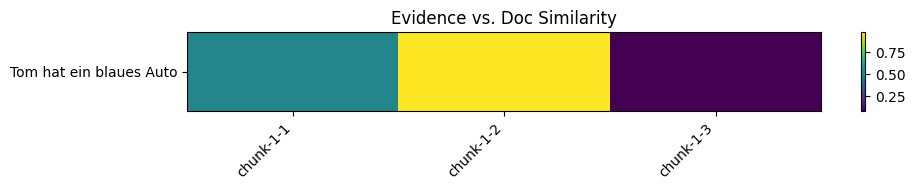

=== Result 1 END ===
=== Result 2 ===
Welches Haustier hat Anna?
Anna hat eine Katze.
Explain metrics: {'duration_seconds': 42.01665608398616, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9965
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9965
  • Max Entailment: 0.9965
  • Avg Neutral: 0.0029
  • Avg Contradiction: 0.0007
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.996)
        "Anna besitzt eine Katze"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 4 tokens
  • Union: 4 tokens

evidence: Anna besitzt eine Katze
  support: chunk-1-2
  rationale: chunk-1-2 states that Anna owns a cat.
Reasoning steps:
    step 1: Anna owns a cat.
      quote: Anna besitzt eine Katze.


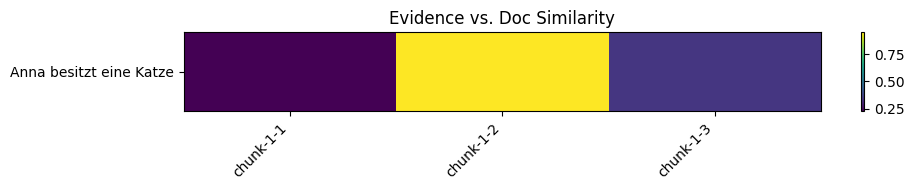

=== Result 2 END ===
=== Result 3 ===
Was ist der Beruf von Sarah?
Sarah arbeitet als Lehrerin an einer Grundschule.
Explain metrics: {'duration_seconds': 43.29701591609046, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.0066
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.0066
  • Max Entailment: 0.0066
  • Avg Neutral: 0.9933
  • Avg Contradiction: 0.0002
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.007)
        "Sarah arbeitet als Lehrerin"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 0.5714
  • Intersection: 4 tokens
  • Union: 7 tokens

evidence: Sarah arbeitet als Lehrerin
  support: chunk-1-1
  rationale: The document chunk-1-1 directly states Sarah's profession as a teacher.
Reasoning steps:
    step 1: Sarah's profession is stated as a teacher.
      quote: Sarah arbeitet als Lehrerin


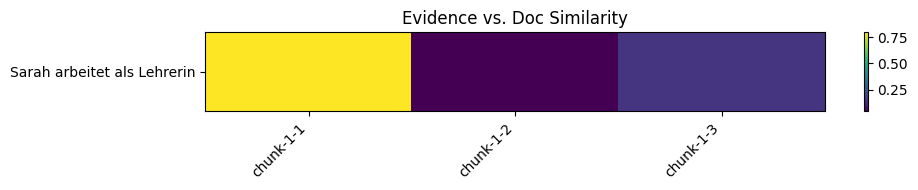

=== Result 3 END ===
=== Result 4 ===
Wo wohnt Klaus?
Klaus wohnt in Berlin.
Explain metrics: {'duration_seconds': 36.94817908294499, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9935
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9935
  • Max Entailment: 0.9935
  • Avg Neutral: 0.0058
  • Avg Contradiction: 0.0007
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.994)
        "Klaus wohnt in Berlin"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 4 tokens
  • Union: 4 tokens

evidence: Klaus wohnt in Berlin
  support: chunk-1-1
  rationale: chunk-1-1 directly states Klaus's residence is Berlin.
Reasoning steps:
    step 1: Klaus wohnt in Berlin.
      quote: Klaus wohnt in Berlin.


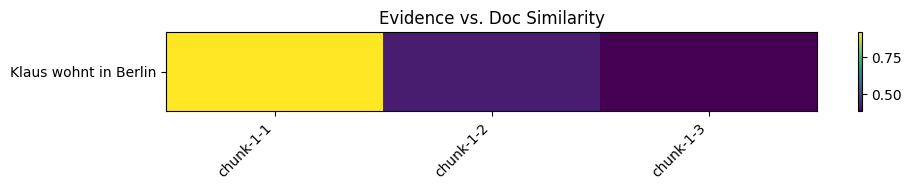

=== Result 4 END ===
=== Result 5 ===
Welches Hobby hat Julia?
Julia spielt gerne Tennis am Wochenende.
Explain metrics: {'duration_seconds': 40.54062304086983, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9576
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9576
  • Max Entailment: 0.9576
  • Avg Neutral: 0.0367
  • Avg Contradiction: 0.0057
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.958)
        "Julia spielt gerne Tennis am Wochenende."

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 6 tokens
  • Union: 6 tokens

evidence: Julia spielt gerne Tennis am Wochenende.
  support: chunk-1-1
  rationale: chunk-1-1 directly states Julia's hobby is playing tennis on weekends.
Reasoning steps:
    step 1: Julia's hobby is playing tennis on weekends.
      quote: Julia spielt gerne Tennis am Wochenende.


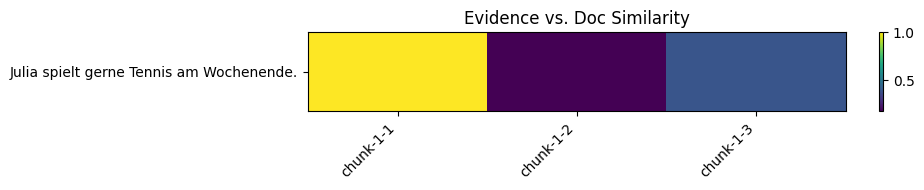

=== Result 5 END ===
=== Result 6 ===
Was ist Marks Lieblingsessen?
Mark isst am liebsten Pizza.
Explain metrics: {'duration_seconds': 39.06523000006564, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9749
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9749
  • Max Entailment: 0.9749
  • Avg Neutral: 0.0178
  • Avg Contradiction: 0.0073
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.975)
        "Mark isst am liebsten Pizza"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 5 tokens
  • Union: 5 tokens

evidence: Mark isst am liebsten Pizza
  support: chunk-1-1
  rationale: chunk-1-1 directly states Mark's favorite food.
Reasoning steps:
    step 1: Mark's favorite food is identified as pizza.
      quote: Mark isst am liebsten Pizza.


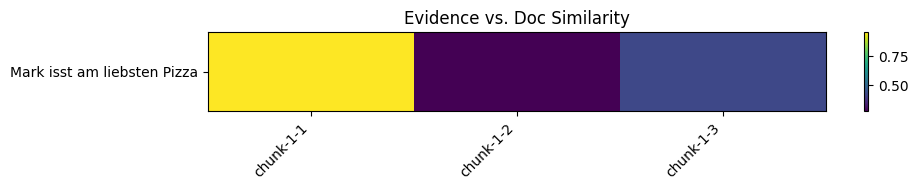

=== Result 6 END ===
=== Result 7 ===
Wie alt ist Emma?
Emma ist 25 Jahre alt.
Explain metrics: {'duration_seconds': 44.31621541688219, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.8388
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.8388
  • Max Entailment: 0.8388
  • Avg Neutral: 0.0787
  • Avg Contradiction: 0.0825
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.839)
        "Emma ist 25 Jahre alt."

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 5 tokens
  • Union: 5 tokens

evidence: Emma ist 25 Jahre alt.
  support: chunk-1-1
  rationale: The document 'chunk-1-1' directly states Emma's age as 25 years.
Reasoning steps:
    step 1: Emma is 25 years old.
      quote: Emma ist 25 Jahre alt.


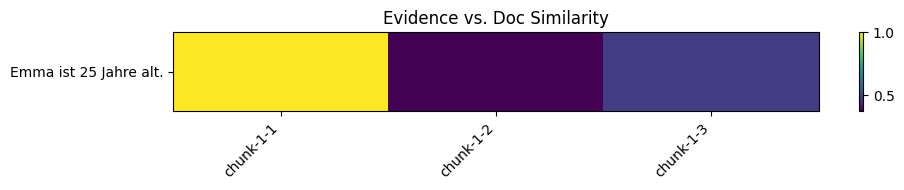

=== Result 7 END ===
=== Result 8 ===
Hat David Kinder?
David hat zwei Kinder.
Explain metrics: {'duration_seconds': 39.60767729207873, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9975
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9975
  • Max Entailment: 0.9975
  • Avg Neutral: 0.0012
  • Avg Contradiction: 0.0013
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.997)
        "David hat zwei Kinder, einen Sohn und eine Tochter."

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 9 tokens
  • Union: 9 tokens

evidence: David hat zwei Kinder, einen Sohn und eine Tochter.
  support: chunk-1-1
  rationale: chunk-1-1 directly states that David has two children, a son and a daughter.
Reasoning steps:
    step 1: David has two children, a son and a daughter.
      quote: David hat zwei Kinder, einen Sohn und eine Tochter.


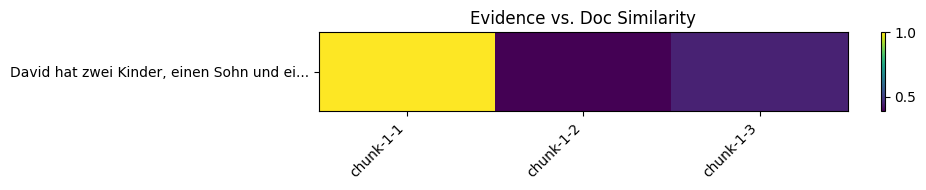

=== Result 8 END ===
=== Result 9 ===
Wohin reist Maria im Urlaub?
Maria fliegt dieses Jahr nach Spanien.
Explain metrics: {'duration_seconds': 38.19935154193081, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.9424
  • Can Derive Answer: ✓ Yes
  • Overall Label: entailment
  • Avg Entailment: 0.9424
  • Max Entailment: 0.9424
  • Avg Neutral: 0.0512
  • Avg Contradiction: 0.0064
  • Per-Evidence Scores:
    [0] ENTAILMENT (ent: 0.942)
        "Maria fliegt dieses Jahr nach Spanien"

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 6 tokens
  • Union: 6 tokens

evidence: Maria fliegt dieses Jahr nach Spanien
  support: chunk-1-1
  rationale: The document chunk-1-1 states that Maria flies to Spain this year.
Reasoning steps:
    step 1: Maria fliegt dieses Jahr nach Spanien.
      quote: Maria fliegt dieses Jahr nach Spanien.


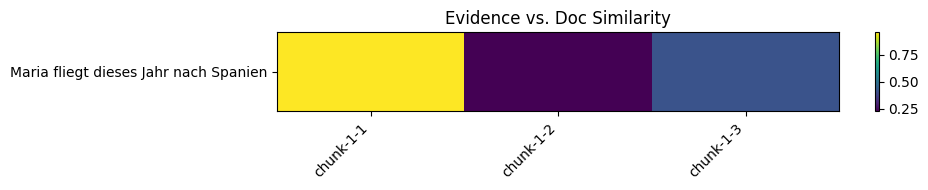

=== Result 9 END ===
=== Result 10 ===
Welche Sportart betreibt Tim?
Fußball
Explain metrics: {'duration_seconds': 37.75091962493025, 'steps': 1}
Evaluation Metrics

📊 Explanation Quality (NLI):
  • NLI Score (Max): 0.1298
  • Can Derive Answer: ✗ No
  • Overall Label: neutral
  • Avg Entailment: 0.1298
  • Max Entailment: 0.1298
  • Avg Neutral: 0.8663
  • Avg Contradiction: 0.0039
  • Per-Evidence Scores:
    [0] NEUTRAL (ent: 0.130)
        "Tim trainiert regelmäßig Fußball im Verein."

🎯 Interpretability (Evidence Overlap):
  • Jaccard Score: 1.0000
  • Intersection: 6 tokens
  • Union: 6 tokens

evidence: Tim trainiert regelmäßig Fußball im Verein.
  support: chunk-1-1
  rationale: The document states that Tim plays football regularly in a club.
Reasoning steps:
    step 1: Tim trainiert regelmäßig Fußball im Verein.
      quote: Tim trainiert regelmäßig Fußball im Verein.


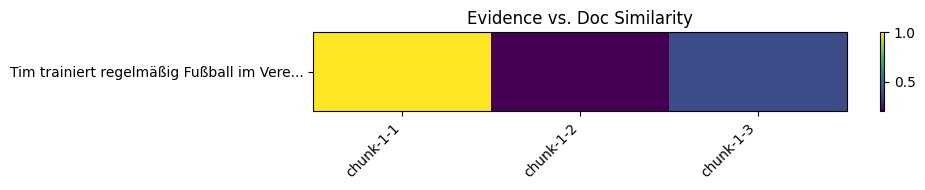

=== Result 10 END ===


In [8]:
for i, res in enumerate(results):
    print(f"=== Result {i + 1} ===")
    print(res["question"])
    print(res["final_answer"])

    result = res["explanation"]
    metrics = res["metrics"]
    cot_metrics = res["cot_metrics"]
    similarity = res["similarity"]
    documents = res["documents"]

    print("Explain metrics:", metrics)
    print(cot_evaluator.prettify(cot_metrics))
    print(CoTExplainable.prettify(result))

    if similarity.get("scores"):
        scores = np.array(similarity["scores"])
        fig, ax = plt.subplots(figsize=(10, max(2, scores.shape[0] * 0.5)))
        im = ax.imshow(scores, aspect="auto", cmap="viridis")
        ax.set_xticks(range(len(similarity["doc_ids"])))
        ax.set_xticklabels(similarity["doc_ids"], rotation=45, ha="right")
        labels = []
        for span in similarity["evidence_spans"]:
            span = span.replace("\n", " ").strip()
            labels.append(span[:40] + "..." if len(span) > 40 else span)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels)
        fig.colorbar(im, ax=ax)
        ax.set_title("Evidence vs. Doc Similarity")
        plt.tight_layout()
        plt.show()
    else:
        print("No similarity matrix to plot.")


    print(f"=== Result {i + 1} END ===")